In [1]:
import sys
sys.path.append('/Users/mariana/Documents/projects/Graphs/egnn')

In [2]:
from ae_datasets import d_selector, Dataloader
from ae_datasets.d_creator import max_n_nodes, DatasetCommunity, DatasetErdosRenyiNodes
import graph as gl

In [3]:
import networkx as nx

In [44]:
import torch

In [4]:
import numpy as np
from torch.nn import functional as F

In [5]:
import matplotlib.pyplot as plt

In [62]:
import yaml
import json
import os
import models
from torch import nn

In [70]:
# Load model
root_pth = '/Users/mariana/Documents/projects/Graphs/EGNN_VAE/nodes_100_erdos/no_coord_dim3/'
# root_pth = '/Users/mariana/Documents/projects/Graphs/EGNN_VAE/nodes_10_erdos/probando'

config = yaml.load(open(os.path.join(root_pth, 'config.yaml'), 'r'), Loader=yaml.FullLoader)
device = 'cpu'

plots = config.get('plots', 0)
exp_name = config.get('exp_name', 'exp_1')
seed = config.get('seed', 1)
outf = config.get('outf', 'outputs_ae')

train = config['train']
epochs = train.get('epochs', 100)
no_cuda = train.get('no-cuda', 0)
log_interval = train.get('log_interval', 100)
test_interval = train.get('test_interval', 2)
generate_interval = train.get('generate-interval', 100)
lr = float(train.get('lr', 1e-4))

data = config['data']
dataset_name = data.get('dataset', 'community_ours')
with_pos = data.get('with_pos', 1)
n_nodes = data.get('n_nodes', 10)
n_communities = data.get('n_communities', 2)
  
model_dict = config['model']
model = model_dict.get('model', 'ae_egnn')
nf = model_dict.get('nf', 64)
emb_nf = model_dict.get('emb_nf', 8)
K = model_dict.get('K', 2)
attention = model_dict.get('attention', 0)
noise_dim = model_dict.get('noise_dim', 0)
n_layers = model_dict.get('n_layers', 4)
reg = float(model_dict.get('reg', 1e-3))
clamp = model_dict.get('clamp', 1)
weight_decay = float(model_dict.get('weight_decay', 1e-16))

In [25]:
dataset = d_selector.retrieve_dataset(dataset_name, K=K, with_pos=with_pos, 
                                      n_nodes=n_nodes, directed=True,
                                      num_communities=n_communities)

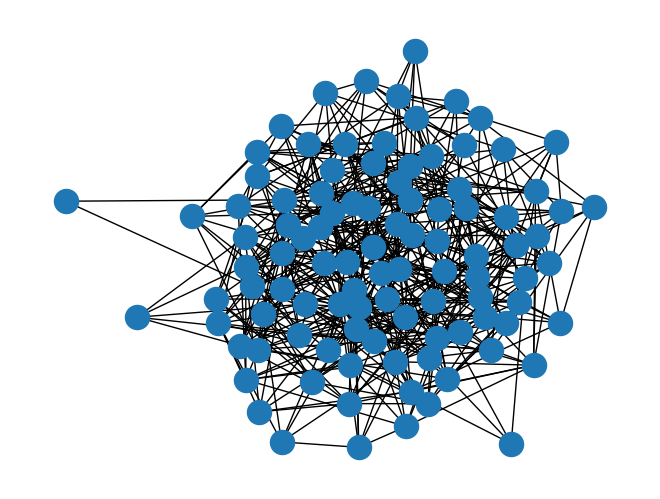

In [26]:
gl.plot_graph(dataset.graphs[122])

In [27]:
def laplacian(adj):
    return np.diag(adj.sum(1)) - adj

def adj_from_lap(lap):
    D = np.diag(np.diag(lap))
    return D - lap

In [29]:
def spectrum(mat, return_val=False):
    val, vec = np.linalg.eig(mat)
    idx = val.argsort()[::-1]   
    val = val[idx]
    vec = vec[:, idx]
    sqr_val = np.sqrt(val)
    sqr_val[np.isnan(sqr_val)] = 0.0
    vec = vec @ np.diag(sqr_val)
    if return_val:
        res = (vec, val)
    else:
        res = vec
    return res

In [30]:
def aprox(vec, K):
    return vec[:, :K] @ vec[:,:K].T

def mse(gt, pred):
    return ((gt - pred)**2).mean()

# def adjacency_error(adj_pred, adj_gt):
#     n_nodes = adj_gt.size(0)
#     adj_pred = (adj_pred > 0.5).type(torch.float32)
#     adj_errors = torch.abs(adj_pred - adj_gt)
#     wrong_edges = torch.sum(adj_errors)
#     adj_error = wrong_edges/ (n_nodes ** 2 - n_nodes)
#     return wrong_edges.item(), adj_error.item()

def adjacency_error(adj_pred, adj_gt):
    n_nodes = adj_gt.shape[0]
    adj_pred = (adj_pred > 0.5).astype(float)
    adj_errors = np.abs(adj_pred - adj_gt)
    wrong_edges = np.sum(adj_errors)
    adj_error = wrong_edges/ (n_nodes ** 2 - n_nodes)
    return wrong_edges, adj_error

# def adj_bce(pred, gt):
#     pred = np.clip(pred, 0, 1)
#     term_0 = (1-gt) * np.log(1-pred + 1e-10)
#     term_1 = gt * np.log(pred + 1e-10)
#     return -np.sum(term_0+term_1)

def adj_bce(pred, gt, reduce='sum', weight=None):
    if isinstance(pred, np.ndarray):
        pred = torch.Tensor(pred).clip(0, 1)
    if isinstance(gt, np.ndarray):
        gt = torch.Tensor(gt).clip(0, 1)
        
    return F.binary_cross_entropy(pred.view(-1, 1), gt.view(-1, 1), reduction=reduce, weight=weight)


In [32]:
adjs = []
for graph in dataset.graphs:
    _, _, _, adj_gt = graph.get_dense_graph(store=True, loops=False)
    adjs.append(adj_gt.numpy())

In [33]:
laps = []
for adj in adjs:
    laps.append(laplacian(adj))

In [34]:
eig = []
for lap in laps:
    vec = spectrum(lap)
    eig.append(vec)

/var/folders/gy/r509yr655150tg12h1t9h_tr0000gn/T/ipykernel_2508/4079672761.py:6: RuntimeWarning: invalid value encountered in sqrt
  sqr_val = np.sqrt(val)


In [35]:
# Ks = [3, 8, 13, 16] For n_nodes = 20
Ks = [3, 10, 20, 50, 80, 90, 100]

d = dict()

for K in Ks:
    
    approximations = []
    for vec in eig:
        approximations.append(aprox(vec, K))
        
    aerrs = []
    for adj_gt, apr in zip(adjs, approximations):
        adj_pred = adj_from_lap(apr)

        _, aerr = adjacency_error(adj_pred, adj_gt)
        aerrs.append(aerr)
    
    d[K] = np.array(aerrs)

[Text(1, 0, '3'),
 Text(2, 0, '10'),
 Text(3, 0, '20'),
 Text(4, 0, '50'),
 Text(5, 0, '80'),
 Text(6, 0, '90'),
 Text(7, 0, '100')]

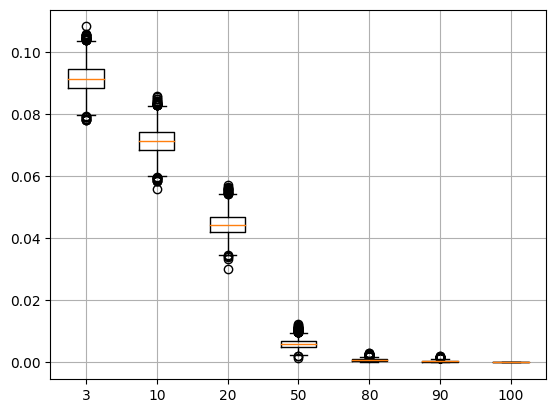

In [36]:
fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.grid()
ax.set_xticklabels(d.keys())

In [37]:
#Check reconstruction error from eigenvectors
#--------------------------------------------

In [45]:
# Ks = [3, 8, 13, 16] For n_nodes = 20
Ks = [3, 10, 20, 50, 80, 90, 100]

d = dict()

for K in Ks:
    
    approximations = []
    for vec in eig:
        approximations.append(aprox(vec, K))
        
    aerrs = []
    for adj_gt, apr in zip(adjs, approximations):
        adj_pred = adj_from_lap(apr)

        aerr = adj_bce(adj_pred, adj_gt)
        aerrs.append(aerr)
    
    d[K] = np.array(aerrs)

[Text(1, 0, '3'),
 Text(2, 0, '10'),
 Text(3, 0, '20'),
 Text(4, 0, '50'),
 Text(5, 0, '80'),
 Text(6, 0, '90'),
 Text(7, 0, '100')]

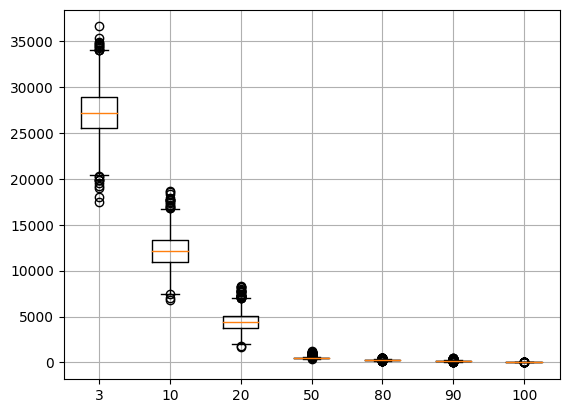

In [46]:
fig, ax = plt.subplots()
ax.boxplot(d.values())
ax.grid()
ax.set_xticklabels(d.keys())

In [63]:
base = json.load(open(os.path.join(root_pth, 'output.json'), 'r'))

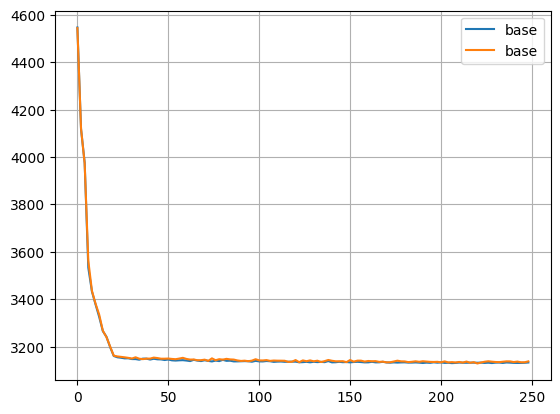

In [64]:
k = 0

plt.plot(base['train']['epoch'][k:], base['train']['bce'][k:], label='base')
plt.plot(base['val']['epoch'][k:], base['val']['bce'][k:], label='base')

plt.legend()
plt.grid()
plt.show()

In [65]:
base['train']['bce'][-1]

3132.471392578125

In [74]:
approximations = []
for vec in eig:
    approximations.append(aprox(vec, 10))

In [81]:
aerrs = []
preds = []
for adj_gt, apr in zip(adjs, approximations):
    adj_pred = adj_from_lap(apr)
    preds.append(adj_pred)

    aerr = adj_bce(adj_pred, adj_gt)
    aerrs.append(aerr)

In [82]:
aerrs = np.array(aerrs)

In [83]:
aerrs.std()

1716.3156

In [88]:
p = np.clip(preds[0], 0, 1)

In [89]:
adjs[0].sum()

982.0

In [99]:
p[adjs[0] != 0].sum()

465.7351

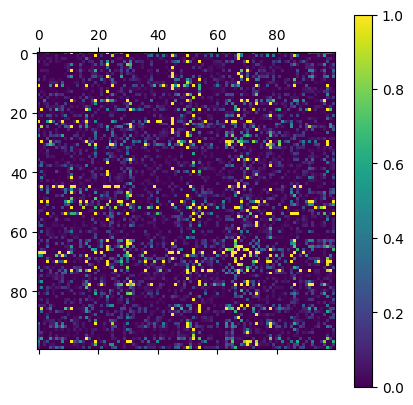

In [102]:
plt.matshow(p)
plt.colorbar()
plt.show()

In [68]:
model_pth = os.path.join(root_pth, 'model.pt')
model = models.AE_EGNN(hidden_nf=nf, K=K, act_fn=nn.SiLU(), device=device, n_layers=n_layers,
                       reg=reg, clamp=clamp)

In [69]:
state_dict = torch.load(model_pth, map_location=device)
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for AE_EGNN:
	Missing key(s) in state_dict: "w", "b". 